<a href="https://colab.research.google.com/github/orlandoalexander/Moda-Personal-Assistant/blob/models/load_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from keras.applications.mobilenet import preprocess_input
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array


In [2]:
import numpy as np

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
from keras.applications.resnet import preprocess_input
from sys import getsizeof
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [4]:
from keras.preprocessing import image


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
classes = {
  "section": [
    "upper",
    "lower",
    "full body",
    "outfit"
  ],
  "category": [
    "Baggy_Pants",
    "Blouses",
    "Cardigans",
    "Dresses",
    "Graphic_Tees",
    "Jackets",
    "Joggers",
    "Pants",
    "Rompers",
    "Shirts",
    "Shorts",
    "Skirts",
    "Suiting",
    "Sweaters",
    "Tees"
  ],
  "design": [
    "floral",
    "graphic",
    "striped",
    "embroidered",
    "pleated",
    "solid",
    "lattice"
  ],
  "sleeves": [
    "long_sleeve",
    "short_sleeve",
    "sleeveless"
  ],
  "length": [
    "maxi_length",
    "mini_length"
  ],
  "neckline": [
    "crew_neckline",
    "v_neckline",
    "square_neckline",
    "no_neckline"
  ],
  "fabric": [
    "denim",
    "chiffon",
    "cotton",
    "leather",
    "faux",
    "knit"
  ],
  "fit": [
    "tight",
    "loose",
    "conventional"
  ]
}


In [260]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Le Wagon/Moda-Personal-Assistant/Data/Current/resnet_design_v1')




In [10]:
model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

In [272]:
url = 'https://images.asos-media.com/products/asos-design-slim-fit-oxford-shirt-in-pink/202576131-1-pink?$n_640w$&wid=634&fit=constrain'
response = requests.get(url)
im = np.asarray(Image.open(BytesIO(response.content)))
IMAGE_SIZE = (224, 224)


In [262]:
resize_dim = (224,224)
pred_class = 'design'

In [263]:
def get_pad_color(image):
  left = image[:,0]
  right = image[:,-1]
  edge_color = (np.concatenate((left, right)).mean(axis=0))
  return edge_color


1/1 [==============================] - 0s 214ms/step
graphic
[('graphic', 0.98785883), ('floral', 0.006735963), ('pleated', 0.0038404248), ('solid', 0.0014378222), ('striped', 6.371092e-05), ('embroidered', 3.604287e-05), ('lattice', 2.7123117e-05)]


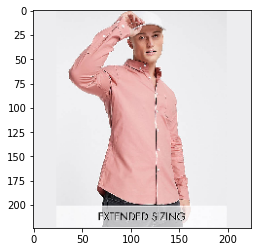

In [273]:
cropped_array = np.asarray(im)

# 'Zoom' image so either x or y dimensions fits corresponding resize dimensions (or as near as possible)
if cropped_array.shape[0] > cropped_array.shape[1]:
    scale = (resize_dim[1]-1)/cropped_array.shape[0]
else:
    scale = (resize_dim[0]-1)/cropped_array.shape[1]
scale_x, scale_y = (scale * dim for dim in cropped_array.shape[:-1])
x, y = np.ogrid[0:scale_x, 0:scale_y]

cropped_array = cropped_array[(x//scale).astype(int), (y//scale).astype(int)]


# Pad missing pixels to resize image to require dimensions
if cropped_array.shape[0] % 2 == 0:
    ax0_pad_left = ax0_pad_right = int((resize_dim[1] - cropped_array.shape[0])/2)
else:
    dif = (resize_dim[1] - cropped_array.shape[0])
    ax0_pad_left = int(dif/2)
    ax0_pad_right=0
    if dif > 0:
        ax0_pad_right = ax0_pad_left + 1

if cropped_array.shape[1] % 2 == 0:
    ax1_pad_left = ax1_pad_right = int((resize_dim[0] - cropped_array.shape[1])/2)
else:
    dif = (resize_dim[0] - cropped_array.shape[1])
    ax1_pad_left = int(dif/2)
    ax1_pad_right=0
    if dif > 0:
        ax1_pad_right = ax1_pad_left + 1


pad_color = get_pad_color(cropped_array)

cropped_pad_array = np.stack([np.pad(cropped_array[:,:,c], ((ax0_pad_left, ax0_pad_right),(ax1_pad_left, ax1_pad_right)), mode='constant', constant_values=pad_color[c]) for c in range(3)], axis=2)
plt.imshow(cropped_pad_array)

cropped_pad_array = cropped_pad_array.reshape((1,cropped_pad_array.shape[0],cropped_pad_array.shape[1],cropped_pad_array.shape[2]))

prediction = model.predict(cropped_pad_array)

predicted_class = tf.math.argmax(prediction[0], axis=-1)
print(classes[pred_class][predicted_class])
res = [(classes[pred_class][index],val) for index, val in enumerate(prediction[0])]
res.sort(key=lambda x: x[1],reverse=True)
print(res)